In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

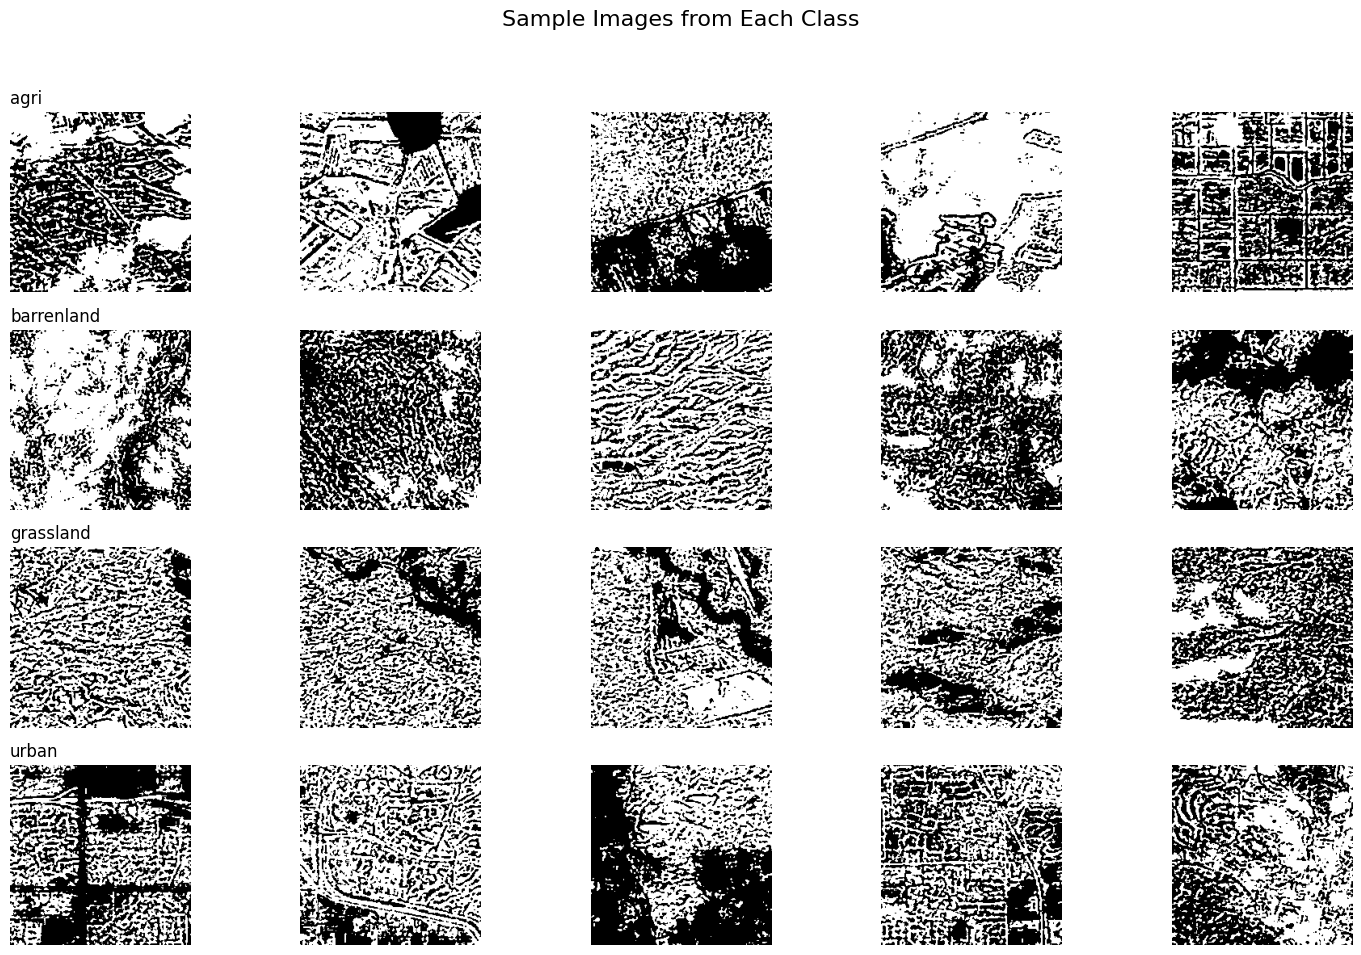

In [1]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the path to the dataset and classes
dataset_path = '/kaggle/input/segmented-sar-segment'
classes = ['agri', 'barrenland', 'grassland', 'urban']
img_size = (224, 224)  # Resize images to this size

# Display 5 random images from each class
num_images = 5
fig, axs = plt.subplots(len(classes), num_images, figsize=(15, 10))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, label in enumerate(classes):
    class_path = os.path.join(dataset_path, label)
    images = os.listdir(class_path)
    selected_images = random.sample(images, num_images)  # Randomly select 5 images

    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize for display purposes

        axs[i, j].imshow(img_array)
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(label, fontsize=12, loc='left')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tqdm import tqdm  # For progress display

# Define paths
original_dataset_path = '/kaggle/input/segmented-sar-segment'
augmented_dataset_path = '/kaggle/working/Augmented_SAR_Segment'
os.makedirs(augmented_dataset_path, exist_ok=True)

# Define augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of augmented images to generate per original image
num_augmented_images = 5

# Apply augmentation to each image in each class folder
for label in os.listdir(original_dataset_path):
    class_path = os.path.join(original_dataset_path, label)
    augmented_class_path = os.path.join(augmented_dataset_path, label)
    os.makedirs(augmented_class_path, exist_ok=True)

    for img_name in tqdm(os.listdir(class_path), desc=f"Augmenting {label}"):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        x = img_to_array(img)  # Convert the image to an array
        x = x.reshape((1,) + x.shape)  # Reshape for the generator

        # Generate augmented images and save them
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_class_path,
                                  save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= num_augmented_images:
                break  # Generate only the specified number of images per original


Augmenting grassland: 100%|██████████| 204/204 [00:11<00:00, 18.19it/s]


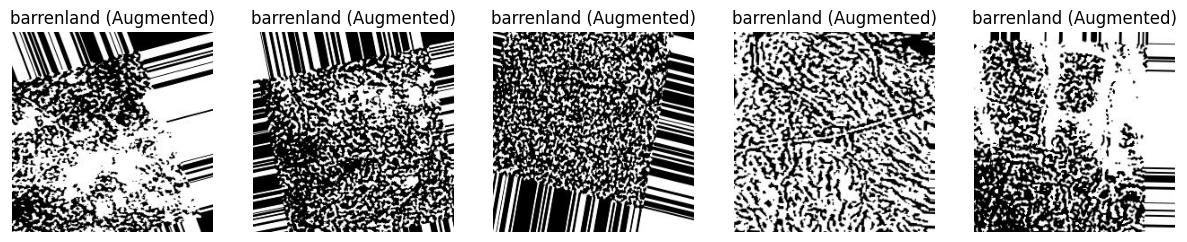

In [3]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img
import glob

# Set the number of images to display
num_samples = 5

# Choose a random class folder from the augmented dataset path
random_class = random.choice(os.listdir(augmented_dataset_path))
class_folder = os.path.join(augmented_dataset_path, random_class)

# Get a list of augmented images in the selected class folder
augmented_images = glob.glob(os.path.join(class_folder, '*.jpeg'))

# Randomly sample images to display
sample_images = random.sample(augmented_images, num_samples)

# Plot the images in a row
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(sample_images):
    img = load_img(img_path)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{random_class} (Augmented)")

plt.show()


In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define paths and parameters
dataset_path = '/kaggle/working/Augmented_SAR_Segment'
img_size = (224, 224)  # VGG19 input size
batch_size = 32
num_classes = 4  # Number of classes

# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2        # Split 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display class indices for verification
print("Class indices:", train_generator.class_indices)


Found 3064 images belonging to 4 classes.
Found 765 images belonging to 4 classes.
Class indices: {'agri': 0, 'barrenland': 1, 'grassland': 2, 'urban': 3}


In [5]:
# Load the VGG19 model, excluding the top (classification) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of VGG19
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Adjust the output layer for the number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Set number of epochs as needed
    verbose=1
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730704541.858186     122 service.cc:145] XLA service 0x787574012fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730704541.858257     122 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/96 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.3047 - loss: 1.5169  

I0000 00:00:1730704552.221638     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 544ms/step - accuracy: 0.3665 - loss: 1.3828 - val_accuracy: 0.5046 - val_loss: 1.0606
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.5069 - loss: 1.0565 - val_accuracy: 0.5686 - val_loss: 0.9856
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.5372 - loss: 1.0148 - val_accuracy: 0.5804 - val_loss: 0.9265
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.5562 - loss: 0.9697 - val_accuracy: 0.6131 - val_loss: 0.8974
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 396ms/step - accuracy: 0.5784 - loss: 0.9499 - val_accuracy: 0.6235 - val_loss: 0.8915
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.5783 - loss: 0.9402 - val_accuracy: 0.6392 - val_loss: 0.8422
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.6239 - loss: 0.9067 - val_accuracy: 0.6536 - val_loss: 0.8299
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.6351 - loss: 0.8737 - val_accuracy: 0.649

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16


In [20]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define paths and parameters
dataset_path = '/kaggle/working/Augmented_SAR_Segment'
img_size = (224, 224)  # VGG19 input size
batch_size = 32
num_classes = 4  # Number of classes

# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2        # Split 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display class indices for verification
print("Class indices:", train_generator.class_indices)


Found 3064 images belonging to 4 classes.
Found 765 images belonging to 4 classes.
Class indices: {'agri': 0, 'barrenland': 1, 'grassland': 2, 'urban': 3}


In [35]:
# Define paths and parameters
dataset_path = '/kaggle/working/Augmented_SAR_Segment'
img_size = (224, 224)  # Input size for ResNet50
batch_size = 32
num_classes = 4  # Number of classes

In [36]:
# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2        # Split 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display class indices for verification
print("Class indices:", train_generator.class_indices)

Found 3064 images belonging to 4 classes.
Found 765 images belonging to 4 classes.
Class indices: {'agri': 0, 'barrenland': 1, 'grassland': 2, 'urban': 3}


In [39]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers to prevent them from being trained initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [38]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Adjust based on your needs
    callbacks=[early_stopping]
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 499ms/step - accuracy: 0.2410 - loss: 1.6884 - val_accuracy: 0.2902 - val_loss: 1.3557
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.2909 - loss: 1.4414 - val_accuracy: 0.3778 - val_loss: 1.3314
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 391ms/step - accuracy: 0.3233 - loss: 1.3683 - val_accuracy: 0.3895 - val_loss: 1.3001
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.3784 - loss: 1.3126 - val_accuracy: 0.4157 - val_loss: 1.2928
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.3980 - loss: 1.2977 - val_accuracy: 0.4013 - val_loss: 1.2679
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.3996 - loss: 1.2824 - val_accuracy: 0.4562 - val_loss: 1.2565
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 397ms/step - accuracy: 0.4056 - loss: 1.2794 - val_accuracy: 0.4588 - val_loss: 1.2468
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.4261 - loss: 1.2531 - val_accu

KeyboardInterrupt: 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
import os
import numpy as np
from PIL import Image
import cv2

# Define the paths for SAR and optical images from the "urban" section
image_path_sar = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/urban/s2'
image_path_sar1 = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2'
image_path_sar2 = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s2'
image_path_sar3= '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/barrenland/s2'

import os
import shutil

# Define the paths for SAR images from different classes
paths = {
    "urban": '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/urban/s2',
    "agri": '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2',
    "grassland": '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/grassland/s2',
    "barrenland": '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/barrenland/s2'
}

# Create a new folder to store the combined dataset
combined_dataset_path = '/kaggle/working/SAR_Segment'
if not os.path.exists(combined_dataset_path):
    os.makedirs(combined_dataset_path)

# Create subdirectories for each class
for label in paths.keys():
    class_path = os.path.join(combined_dataset_path, label)
    if not os.path.exists(class_path):
        os.makedirs(class_path)

# Copy the images to the respective folders in the combined dataset
for label, image_path in paths.items():
    for image_name in os.listdir(image_path):
        src = os.path.join(image_path, image_name)
        dst = os.path.join(combined_dataset_path, label, image_name)
        shutil.copy(src, dst)

print("Dataset successfully combined into SAR_Segment with 4 classes.")




Dataset successfully combined into SAR_Segment with 4 classes.


In [45]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [46]:
# Set paths
base_dir = '/kaggle/working/SAR_Segment'

# Image data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of data for validation
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Resize to VGG input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [47]:
# Load VGG19 model + higher level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=2,  # Adjust number of epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8699 - loss: 0.3552

KeyboardInterrupt: 

In [ ]:
# Evaluate the model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')


In [51]:
!pip install git+https://github.com/scikit-fuzzy/scikit-fuzzy


  Cloning https://github.com/scikit-fuzzy/scikit-fuzzy to /tmp/pip-req-build-sa84wb61
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-fuzzy/scikit-fuzzy /tmp/pip-req-build-sa84wb61
  Resolved https://github.com/scikit-fuzzy/scikit-fuzzy to commit be7e344f3ce65845e39922aa5fc1af7412d01944
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.5.0-py2.py3-none-any.whl size=920818 sha256=c150ebe4ef5057393f5f2ed80e89f8786662731e59cc44bb17162aaeb159bce8
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxaqbwmn/wheels/82/d5/72/3e485c7a9b1a08d3b9f5d416c9990d987dc5138c319917a9db
Successfully built scikit-fuzzy


In [55]:
import os
import numpy as np
from PIL import Image
import skfuzzy as fuzz
from skfuzzy.cluster import cmeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# Define paths for input (filtered images) and output (segmented images)
filtered_dataset_path = '/kaggle/working/SAR_Segment'
segmented_dataset_path = '/kaggle/working/Segmented_SAR_Segment'

# Ensure the output directory exists, creating subdirectories for each class
if not os.path.exists(segmented_dataset_path):
    os.makedirs(segmented_dataset_path)

for label in os.listdir(filtered_dataset_path):
    label_output_path = os.path.join(segmented_dataset_path, label)
    if not os.path.exists(label_output_path):
        os.makedirs(label_output_path)

# Function to load images and resize them for processing
def load_images(dataset_path, sample_percentage=0.5, img_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = Image.open(img_path)
            img = img.resize(img_size)
            images.append(np.array(img))
            labels.append((label, img_name))
    # Sample 50% of the images
    _, sampled_images, _, sampled_labels = train_test_split(images, labels, test_size=sample_percentage, random_state=42)
    return sampled_images, sampled_labels

# Load 50% of the dataset
sampled_images, sampled_labels = load_images(filtered_dataset_path, sample_percentage=0.5)

# Function to apply Fuzzy C-means and save segmented images
def fuzzy_cmeans_clustering(image, num_clusters=2):
    # Reshape image to a 2D array (pixels x channels)
    img_2d = image.reshape(-1, 3).T  # Transpose for skfuzzy

    # Apply Fuzzy C-means
    cntr, u, _, _, _, _, _ = cmeans(
        img_2d, c=num_clusters, m=1.5, error=0.005, maxiter=1000, init=None
    )
    
    # Get the hard clustering result by finding the max probability for each pixel
    cluster_membership = np.argmax(u, axis=0)
    segmented_image = cluster_membership.reshape(image.shape[:2])

    return segmented_image

# Apply Fuzzy C-means on the sampled dataset and save the segmented images
for (image, (label, img_name)) in tqdm(zip(sampled_images, sampled_labels), total=len(sampled_images), desc="Processing Images"):
    # Apply Fuzzy C-means
    segmented_image = fuzzy_cmeans_clustering(image)
    
    # Convert the segmented image to RGB format for saving
    segmented_rgb_image = Image.fromarray((segmented_image * (255 // segmented_image.max())).astype(np.uint8))

    # Save the segmented image in the corresponding class folder in the segmented dataset path
    output_label_path = os.path.join(segmented_dataset_path, label)
    segmented_rgb_image.save(os.path.join(output_label_path, img_name))

print("50% of the dataset has been segmented and saved in 'Segmented_SAR_Segment'.")


Processing Images: 100%|██████████| 8000/8000 [1:11:22<00:00,  1.87it/s]

50% of the dataset has been segmented and saved in 'Segmented_SAR_Segment'.


In [56]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to the segmented images
segmented_dataset_path = '/kaggle/working/Segmented_SAR_Segment'

# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of data for validation
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    segmented_dataset_path,
    target_size=(224, 224),  # VGG19 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    segmented_dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 6401 images belonging to 4 classes.
Found 1599 images belonging to 4 classes.


In [57]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Number of classes in your dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Adjust number of epochs based on your needs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 86s 408ms/step - accuracy: 0.6201 - loss: 0.9016 - val_accuracy: 0.7188 - val_loss: 0.6560
Epoch 2/10
  1/200 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.8438 - loss: 0.5153

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8438 - loss: 0.5153 - val_accuracy: 0.7419 - val_loss: 0.4984
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - accuracy: 0.8165 - loss: 0.4659 - val_accuracy: 0.7251 - val_loss: 0.6483
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.6111 - val_accuracy: 0.7419 - val_loss: 0.6957
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 397ms/step - accuracy: 0.8231 - loss: 0.4468 - val_accuracy: 0.7188 - val_loss: 0.6490
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2686 - val_accuracy: 0.7097 - val_loss: 0.8020
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 399ms/step - accuracy: 0.8246 - loss: 0.4498 - val_accuracy: 0.7730 - val_loss: 0.5403
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.6688 - val_accuracy: 0.6452 - val_loss: 0.7509
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.8448 - loss: 0.3956 - val_accuracy: 

In [59]:
# Evaluate the model on validation data
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - accuracy: 0.7329 - loss: 0.7126
Validation Loss: 0.6679248809814453, Validation Accuracy: 0.7335835099220276


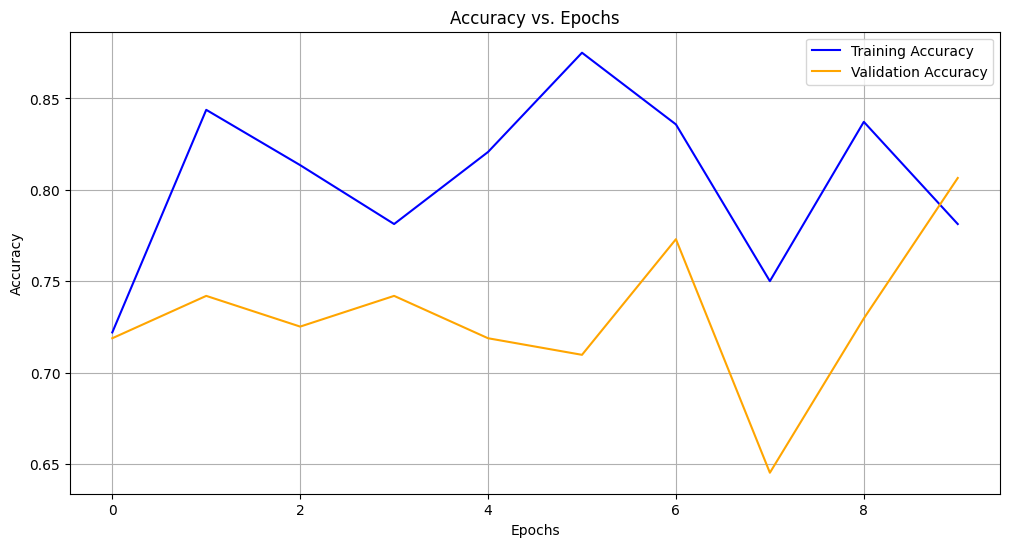

Maximum Training Accuracy: 0.8750
Maximum Validation Accuracy: 0.8065


In [60]:
# Step 1: Plot Accuracy vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Step 2: Get Maximum Accuracy
max_train_accuracy = max(history.history['accuracy'])
max_val_accuracy = max(history.history['val_accuracy'])

print(f"Maximum Training Accuracy: {max_train_accuracy:.4f}")
print(f"Maximum Validation Accuracy: {max_val_accuracy:.4f}")